# Preparation

## Download CellBender corrected count matrices

In [1]:
system('wget -O 05pka_cellbender_filtered.h5 -nc https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4859nnn/GSM4859875/suppl/GSM4859875_05pka_cellbender_filtered.h5')
system('wget -O 100pka_cellbender_filtered.h5 -nc  https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4859nnn/GSM4859876/suppl/GSM4859876_100pka_cellbender_filtered.h5')

## Load libraries and functions

In [2]:
suppressPackageStartupMessages({
library(pagoda2)
library(Seurat)
library(SingleCellExperiment)
library(reticulate)
})

doUMAP <- function(PCA,n_neighbors,min_dist,max_dim=2,seed.use=42){
  require(reticulate)
  if (!is.null(x = seed.use)) {
    set.seed(seed = seed.use)
    py_set_seed(seed = seed.use)
  }
  umap_import <- import(module = "umap", delay_load = TRUE)
  umap <- umap_import$UMAP(n_neighbors = as.integer(x = n_neighbors), 
                           n_components = as.integer(x = max_dim), metric = "correlation", 
                           min_dist = min_dist)
  
  umap_output <- umap$fit_transform(as.matrix(x = PCA))
  rownames(umap_output)=rownames(PCA)
  colnames(umap_output)=paste0("UMAP",1:max_dim)
  
  return(umap_output)
}

p2wrapper <- function(counts,n_neighbors=30,min_dist=0.3,k=100,npcs=200,selpc=T,...) {
  rownames(counts) <- make.unique(rownames(counts))
  p2 <- Pagoda2$new(counts,log.scale=FALSE,n.cores=parallel::detectCores()/2,...)
  p2$adjustVariance(plot=T,gam.k=10)
  p2$calculatePcaReduction(nPcs=npcs,n.odgenes=NULL,maxit=1000)
  if (selpc){
    x <- cbind(1:npcs, p2$misc$PCA$d)
    line <- x[c(1, nrow(x)),]
    proj <- princurve::project_to_curve(x, line)
    optpoint <- which.max(proj$dist_ind)-1
    dev.new(width=5, height=4)
    par(mfrow=c(1,1))
    plot(x,xlab="PC", ylab="Variance explained")
    abline(v=optpoint,lty=2,col=2)
    cat(paste0(optpoint," PCs retained\n"))
    npcs=optpoint
    p2$calculatePcaReduction(use.odgenes = T, name='PCA', 
                             nPcs=optpoint, maxit=1000)
  }
  
  p2$makeKnnGraph(k=k,type='PCA',center=T,distance='cosine');
  p2$getKnnClusters(method=conos::leiden.community,type='PCA',name = "leiden",resolution=.5)
  
  # Produce UMAP embedding
  cat("Computing UMAP... ")
  p2$embeddings$PCA$UMAP=doUMAP(PCA = p2$reductions$PCA[,1:npcs],n_neighbors = n_neighbors,min_dist = min_dist)
  cat("done\n")
  invisible(p2)
}

p2.generate.mouse.go.web <- function(gene.names, n.cores = 1) {
  if (!requireNamespace("org.Mm.eg.db", quietly = TRUE)) {
    stop("Package \"org.Mm.eg.db\" needed for this function to work. Please install it.", call. = FALSE)
  }

  p2.generate.go.web(gene.names = gene.names,  egALIAS2EG = org.Mm.eg.db::org.Mm.egALIAS2EG, 
                     egGO2ALLEGS = org.Mm.eg.db::org.Mm.egGO2ALLEGS, n.cores = n.cores)
}
p2.generate.go.web  <- function (gene.names, egALIAS2EG = NULL, egGO2ALLEGS = NULL, n.cores = 1) {
  if (!requireNamespace("GO.db", quietly = TRUE)) {
    stop("Package \"GO.db\" needed for this function to work. Please install it with `BiocManager::install('GO.db')`.", call. = FALSE)
  }

  if (is.null(egALIAS2EG)) {
    stop("egALIAS2EG cannot be null, it has to be an object like org.Hs.egALIAS2EG")
  }

  if (!is.character(gene.names)) {
    stop("gene.names needs to be a character vector of gene names")
  }

  if (!requireNamespace("AnnotationDbi", quietly = TRUE)) {
    stop("Package \"AnnotationDbi\" needed for this function to work. Please install it with `BiocManager::install('AnnotationDbi')`.", call. = FALSE)
  }

  ids <- unlist(mclapply(AnnotationDbi::mget(gene.names, egALIAS2EG, ifnotfound = NA), function(x) x[1], mc.cores = n.cores))
  rids <- names(ids)
  names(rids) <- ids
  go.env <- AnnotationDbi::eapply(egGO2ALLEGS, function(x) as.character(na.omit(rids[x])))
  go.env <- go.env[unlist(lapply(go.env, length)) > 5]

  ## Put the GO Term annotation generated in a format suitable for the web interface
  nms <- names(go.env)
  names(nms) <- nms
  geneSets <- lapply(nms, function(x) {
    list(
      properties = list(
        locked = TRUE,
        genesetname = x,
        shortdescription = GO.db::GOTERM[[x]]@Term
      ),
      genes = c(go.env[[x]])
    )
  })

  invisible(geneSets)
}

In [3]:
use_condaenv("muscle2", required = TRUE)

# Processing

## Read and filter count matrices, generate PCA 

In [4]:
pka100=Seurat::Read10X_h5("100pka_cellbender_filtered.h5")
pka05=Seurat::Read10X_h5("05pka_cellbender_filtered.h5")

colnames(pka100)=paste0("hard_",colnames(pka100))
colnames(pka05)=paste0("soft_",colnames(pka05))

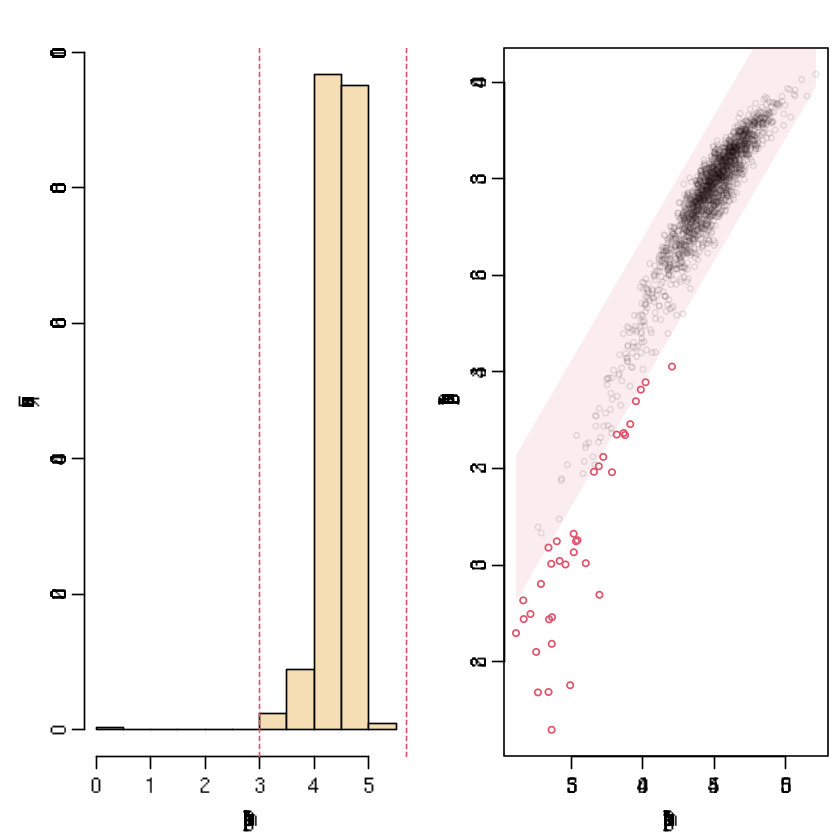

2006 cells, 27998 genes; normalizing ... 

Using plain model 

done.


calculating variance fit ...

 using gam 

1970 overdispersed genes ... 1970

persisting ... 

 using gam 

done.

running PCA using 1970 OD genes .

.

.

.

 done




18 PCs retained


running PCA using 1970 OD genes .

.

.

.

 done




creating space of type angular done
adding data ... done
building index ... done
querying ... done
Computing UMAP... done


1823 cells, 27998 genes; normalizing ... 

Using plain model 

done.


calculating variance fit ...

 using gam 

2926 overdispersed genes ... 2926

persisting ... 

 using gam 

done.

running PCA using 2926 OD genes .

.

.

.

 done




32 PCs retained


running PCA using 2926 OD genes .

.

.

.

 done




creating space of type angular done
adding data ... done
building index ... done
querying ... done
Computing UMAP... done


3829 cells, 17926 genes; normalizing ... 

Using plain model 

Batch ... 

done.


calculating variance fit ...

 using gam 

2893 overdispersed genes ... 2893

persisting ... 

 using gam 

done.

running PCA using 2893 OD genes .

.

.

.

 done




14 PCs retained


running PCA using 2893 OD genes .

.

.

.

 done




creating space of type angular done
adding data ... done
building index ... done
querying ... done
Computing UMAP... done


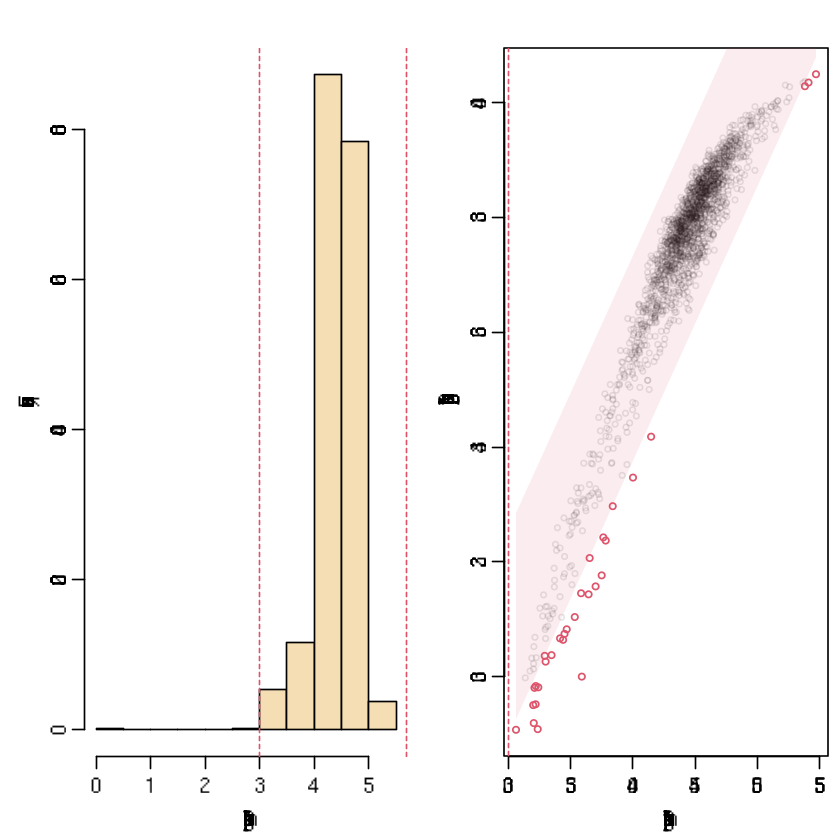

In [5]:
cd <- lapply(list(pka100,pka05),function(y) {
  y=gene.vs.molecule.cell.filter(y,max.cell.size = 5e5,min.cell.size = 1e3)
  mito.genes <- grep(pattern = "^mt-", x = rownames(x = y), value = TRUE)
  percent.mito <- Matrix::colSums(y[mito.genes, ])/Matrix::colSums(y)
  y = y[,percent.mito<.1]
  return(y)})

counts <- do.call(cbind,cd)

p2l=lapply(cd,function(x) p2wrapper(as(x,"dgCMatrix")))

batch=factor(sapply(strsplit(colnames(counts),"_"),"[[",1))
names(batch)=colnames(counts)
           
counts=counts[rowSums(counts)!=0,]

p2=p2wrapper(counts,batch=batch)

## Clustering and UMAP embedding

<div class="alert alert-warning">
<b>Warning</b> Clustering is not reproducible!
</div>

In [6]:
p2$getKnnClusters(method=conos::leiden.community,type='PCA',name = "leiden",resolution=1)

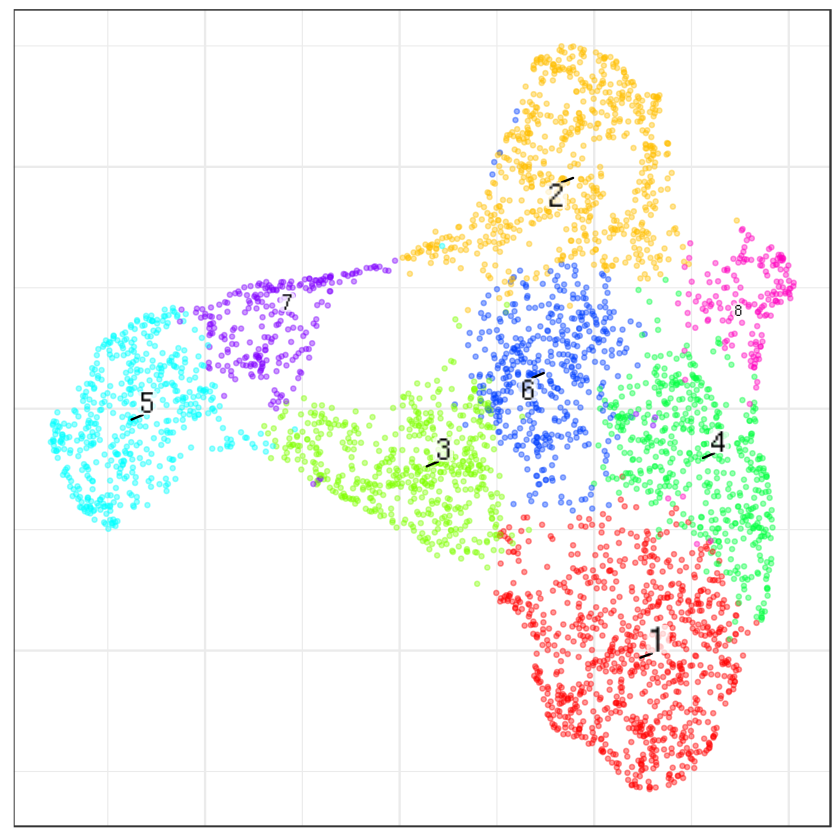

In [7]:
p2$plotEmbedding(type='PCA',embeddingType='UMAP')

### publication clustering

In [8]:
leiden=factor(read.csv("data/clusters_all.csv")$x)
names(leiden)=read.csv("data/clusters_all.csv")$X

In [9]:
p2$clusters$PCA$leiden=leiden

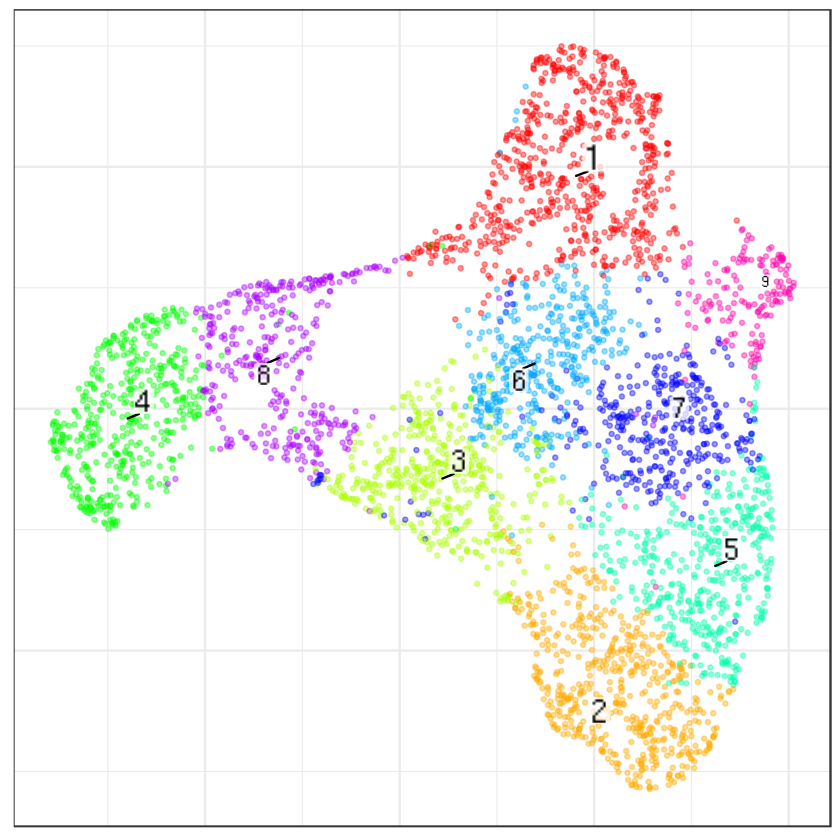

In [10]:
p2$plotEmbedding(type='PCA',embeddingType='UMAP')

## Convert to SingleCellExperiment for anndata conversion

In [14]:
adata <- SingleCellExperiment(list(counts=t(p2$misc$rawCounts),logcounts=t(p2$counts)),
    colData=DataFrame(leiden=as.character(p2$clusters$PCA$leiden),
                      condition=sapply(strsplit(rownames(p2$counts),"_"),"[[",1)),
    metadata=list(study="combined")
)


reducedDims(adata) <- list(pca=p2$reductions$PCA,
                         umap=p2$embeddings$PCA$UMAP)

batch=adata$condition;names(batch)=rownames(p2$counts);batch=factor(batch)

In [15]:
save(adata,file="adata_combined.RData")

## Pathway overdispersion

In [ ]:
library(RhpcBLASctl)
blas_set_num_threads(1)

In [ ]:
p2$n.cores=50
go.env <- p2.generate.mouse.go(p2)
p2$testPathwayOverdispersion(setenv = go.env,
                                     recalculate.pca=T,
                                     correlation.distance.threshold = 0.95,verbose = T)

myGeneNames <- colnames(p2$counts)

In [ ]:
library(parallel)

In [ ]:
goSets <- p2.generate.mouse.go.web(myGeneNames)
deSets <- get.de.geneset(p2, groups = p2$clusters$PCA$leiden, prefix = 'de_')
geneSets <- c(goSets, deSets)

palette=c("#8DD3C7","#FFFFB3","#BEBADA","#FB8072","#80B1D3","#FDB462","#B3DE69","#FCCDE5","#D9D9D9")

additionalMetadata=list()
additionalMetadata$leiden <- p2.metadata.from.factor(p2$clusters$PCA$leiden, 
                                                     displayname = 'Leiden', 
                                                     s = 0.7, v = 0.8,start = 0, end = 0.5,
                                                     pal = palette)

additionalMetadata$condition <- p2.metadata.from.factor(batch, 
                                                  displayname = 'Condition', 
                                                  s = 0.7, 
                                                  v = 0.8,
                                                  start = 0, 
                                                  end = 0.5)


p2w <- make.p2.app(
  p2,
  dendrogramCellGroups = p2$clusters$PCA$leiden,
  additionalMetadata = additionalMetadata,
  geneSets = geneSets,
  show.clusters = FALSE # Hide the clusters that were used for the dendrogram from the metadata
)

## Generate pagoda2 web app

In [ ]:
p2$makeGeneKnnGraph(n.cores = 40)

In [ ]:
p2w$serializeToStaticFast("p2w_batch_corrected.bin")
save(p2w,file="p2w_batch_corrected.RData")